In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *
from fastai.structured import *
from fastai.column_data import *

from math import ceil

from itertools import product
import gc
from dateutil import parser

In [2]:
torch.cuda.set_device(0)

In [3]:
import fastai; fastai.__file__

'/home/paperspace/fastai/fastai/__init__.py'

In [4]:
PATH = "data/"
sz=224
arch=resnext101_64
batch_size=5

## Feature Engineering

In [ ]:
item_categories = pd.read_csv(f'{PATH}item_categories.csv')
items = pd.read_csv(f'{PATH}items.csv')
shops = pd.read_csv(f'{PATH}shops.csv')
sales = pd.read_csv(f'{PATH}sales_train.csv')
sales_test = pd.read_csv(f'{PATH}test.csv')

In [ ]:
index_cols  = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'},'item_price': np.mean})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
# all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
all_data = pd.merge(grid,gb,how='left',on=index_cols)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

del grid,gb,cur_shops,cur_items
del sales
gc.collect()

In [ ]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

all_data.fillna(0.0,inplace=True)
all_data['target'] = all_data['target'].clip(0.0,20.0)
all_data['month'] = all_data['date_block_num'] % 12
all_data['year'] = all_data['date_block_num'] // 12

sales_test['date_block_num'] = 34
sales_test['month'] = sales_test['date_block_num']%12
sales_test['year'] = sales_test['date_block_num']//12

all_data = pd.concat([all_data,sales_test])

del sales_test
gc.collect()

In [ ]:
all_data = all_data.merge(items, on="item_id")
all_data.drop('item_name',axis = 1,inplace=True)
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data = downcast_dtypes(all_data)

del items
gc.collect()

In [ ]:
lag_variable = ['target']
lags = [1 ,2 ,3 ,4, 5, 12]
for lag in lags:
    sales_new_df = all_data[['date_block_num','shop_id','item_id']+lag_variable].copy()
    sales_new_df.date_block_num+=lag
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variable]
    all_data = pd.merge(all_data, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')
    del sales_new_df
    gc.collect()

for feat in all_data.columns:
    if 'target' in feat:
        all_data[feat]=all_data[feat].fillna(0)

In [ ]:

all_data['avg_sales_per_shop_id'] = 0.0
all_data['avg_sales_per_item_id'] = 0.0
all_data['avg_sales_per_item_cat_id'] = 0.0

avg_shop_sales_per_month = all_data.groupby(['shop_id','date_block_num'],as_index=False).agg({'target':'mean'})
avg_item_sales_per_month = all_data.groupby(['item_id','date_block_num'],as_index=False).agg({'target':'mean'})
avg_item_cat_sales_per_month = all_data.groupby(['item_category_id','date_block_num'],as_index=False).agg({'target':'mean'})

#lets calculate  6 lags
lag_variable = ['item_id','shop_id','item_category_id']
lags = [1 ,2 ,3 ,4, 5, 12]
curr = 0
for lag in lags:
    diff = lag - curr
    curr = lag
    avg_shop_sales_per_month.date_block_num+=diff
    avg_item_cat_sales_per_month.date_block_num+=diff
    avg_item_sales_per_month.date_block_num+=diff
    
    avg_shop_sales_per_month.columns = ['shop_id','date_block_num']+ [lag_variable[1]+'_lag_'+str(lag)]
    avg_item_sales_per_month.columns = ['item_id','date_block_num']+ [lag_variable[0]+'_lag_'+str(lag)]
    avg_item_cat_sales_per_month.columns = ['item_category_id','date_block_num']+ [lag_variable[2]+'_lag_'+str(lag)]
    
    all_data = pd.merge(all_data, avg_shop_sales_per_month,on=['date_block_num','shop_id'] ,how='left')
    all_data = pd.merge(all_data, avg_item_sales_per_month,on=['date_block_num','item_id'] ,how='left')
    all_data = pd.merge(all_data, avg_item_cat_sales_per_month,on=['date_block_num','item_category_id'] ,how='left')
    
    gc.collect()
del avg_item_cat_sales_per_month,avg_item_sales_per_month,avg_shop_sales_per_month

In [ ]:
all_data.drop(columns=['mean'],inplace=True)
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [ ]:
all_data.fillna(0,inplace=True)
gc.collect()

In [ ]:
all_data.to_pickle(PATH + 'all_data.pkl')

In [5]:
all_data = pd.read_pickle(PATH + 'all_data.pkl')

In [6]:
cat_vars = [
    'date_block_num',
    'item_id',
    'month',
    'shop_id',
    'year',
    'item_category_id',
]
contin_vars = [
    x for x in list(all_data.columns) if x not in cat_vars + ['ID'] # exclude ID
]
dep = 'target'

In [7]:
all_data.columns

Index(['ID', 'date_block_num', 'item_id', 'month', 'shop_id', 'target', 'year',
       'item_category_id', 'target_lag_1', 'target_lag_2', 'target_lag_3',
       'target_lag_4', 'target_lag_5', 'target_lag_12',
       'avg_sales_per_shop_id', 'avg_sales_per_item_id',
       'avg_sales_per_item_cat_id', 'shop_id_lag_1', 'item_id_lag_1',
       'item_category_id_lag_1', 'shop_id_lag_2', 'item_id_lag_2',
       'item_category_id_lag_2', 'shop_id_lag_3', 'item_id_lag_3',
       'item_category_id_lag_3', 'shop_id_lag_4', 'item_id_lag_4',
       'item_category_id_lag_4', 'shop_id_lag_5', 'item_id_lag_5',
       'item_category_id_lag_5', 'shop_id_lag_12', 'item_id_lag_12',
       'item_category_id_lag_12'],
      dtype='object')

In [8]:
for cat in cat_vars:
    all_data[cat] = all_data[cat].astype('category').cat.as_ordered()

In [9]:
X_train = all_data[(all_data['date_block_num']>12)&(all_data['date_block_num']<33)].drop(['target','ID'], axis = 1)
y_train = all_data[(all_data['date_block_num']>12)&(all_data['date_block_num']<33)]['target']
X_val =  all_data[all_data['date_block_num']==33].drop(['target','ID'], axis = 1)
y_val = all_data[all_data['date_block_num'] == 33]['target']
X_test = all_data[(all_data['date_block_num']==34)].drop(['target'],axis=1)
del all_data

In [26]:
X_test = X_test.drop('ID', axis=1)

In [13]:
gc.collect()

235

In [29]:
X_train.to_pickle(PATH + 'X_train.pkl')
y_train.to_pickle(PATH + 'y_train.pkl')
X_val.to_pickle(PATH + 'X_val.pkl')
y_val.to_pickle(PATH + 'y_val.pkl')
X_test.to_pickle(PATH + 'X_test.pkl')

In [30]:
X_train.head()

,date_block_num,item_id,month,shop_id,year,item_category_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,...,item_category_id_lag_3,shop_id_lag_4,item_id_lag_4,item_category_id_lag_4,shop_id_lag_5,item_id_lag_5,item_category_id_lag_5,shop_id_lag_12,item_id_lag_12,item_category_id_lag_12
4836102,13,30,1,2,1,40,0.0,0.0,0.0,0.0,...,0.244913,0.089066,0.521739,0.236217,0.107034,0.288889,0.227597,0.059868,12.456522,0.266213
4836103,13,31,1,2,1,37,0.0,0.0,0.0,0.0,...,0.183129,0.089066,0.543478,0.170779,0.107034,0.422222,0.198978,0.059868,11.195652,0.196096
4836104,13,32,1,2,1,40,1.0,0.0,0.0,0.0,...,0.244913,0.089066,1.260870,0.236217,0.107034,1.311111,0.227597,0.059868,4.478261,0.266213
4836105,13,33,1,2,1,37,1.0,1.0,2.0,0.0,...,0.183129,0.089066,0.717391,0.170779,0.107034,0.955556,0.198978,0.059868,0.847826,0.196096
4836106,13,34,1,2,1,40,0.0,0.0,0.0,0.0,...,0.244913,0.089066,0.043478,0.236217,0.107034,0.200000,0.227597,0.059868,0.239130,0.266213


In [31]:
X_test.head()

,date_block_num,item_id,month,shop_id,year,item_category_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,...,item_category_id_lag_3,shop_id_lag_4,item_id_lag_4,item_category_id_lag_4,shop_id_lag_5,item_id_lag_5,item_category_id_lag_5,shop_id_lag_12,item_id_lag_12,item_category_id_lag_12
10930345,34,5037,10,5,2,19,0.0,1.0,3.0,1.0,...,0.673160,0.179786,1.255814,0.447921,0.179064,2.441860,0.493052,0.206106,1.3,0.617857
10930404,34,5320,10,5,2,55,0.0,0.0,0.0,0.0,...,0.217244,0.179786,0.000000,0.216664,0.179064,0.000000,0.207304,0.206106,0.0,0.248076
10930389,34,5233,10,5,2,19,1.0,3.0,1.0,0.0,...,0.673160,0.179786,0.860465,0.447921,0.179064,2.767442,0.493052,0.206106,0.0,0.617857
10930388,34,5232,10,5,2,23,0.0,0.0,1.0,0.0,...,0.555861,0.179786,0.000000,0.419365,0.179064,0.000000,0.462636,0.206106,0.0,0.667134
10930395,34,5268,10,5,2,20,0.0,0.0,0.0,0.0,...,1.061809,0.179786,0.000000,0.880698,0.179064,0.000000,0.979093,0.206106,0.0,2.412464


# Training

## _Deep Learning Approach_

In [32]:
def rmse(y_pred, targ):
    return math.sqrt(((targ - y_pred)**2).mean())

In [33]:
X_train['target'] = y_train
X_val['target'] = y_val
X_test['target'] = 0
df, y, nas, mapper = proc_df(X_train, 'target', do_scale=True)
val_df, val_y, nas, mapper = proc_df(
    X_val,
    dep,
    do_scale=True,
    mapper=mapper,
)
test_df, _, nas, mapper = proc_df(
    X_test,
    dep,
    do_scale=True,
    mapper=mapper,
)

In [34]:
test_df.columns

Index(['date_block_num', 'item_id', 'month', 'shop_id', 'year',
       'item_category_id', 'target_lag_1', 'target_lag_2', 'target_lag_3',
       'target_lag_4', 'target_lag_5', 'target_lag_12',
       'avg_sales_per_shop_id', 'avg_sales_per_item_id',
       'avg_sales_per_item_cat_id', 'shop_id_lag_1', 'item_id_lag_1',
       'item_category_id_lag_1', 'shop_id_lag_2', 'item_id_lag_2',
       'item_category_id_lag_2', 'shop_id_lag_3', 'item_id_lag_3',
       'item_category_id_lag_3', 'shop_id_lag_4', 'item_id_lag_4',
       'item_category_id_lag_4', 'shop_id_lag_5', 'item_id_lag_5',
       'item_category_id_lag_5', 'shop_id_lag_12', 'item_id_lag_12',
       'item_category_id_lag_12'],
      dtype='object')

In [35]:
y_train = np.log1p(y.clip(0.,40.))
y_val = np.log1p(val_y.clip(0.,40.))

In [36]:
md = ColumnarModelData.from_data_frames(
    path=PATH,
    trn_df=df,
    trn_y=y_train,
    val_df=val_df,
    val_y=y_val,
    cat_flds=cat_vars,
    bs=256,
    test_df=test_df,
    is_reg=True,  # is regression
    is_multi=False, 
)

In [37]:
cat_sz = [(c, len(X_train[c].cat.categories)+1) for c in cat_vars]

In [38]:
cat_sz

[('date_block_num', 36),
 ('item_id', 22171),
 ('month', 13),
 ('shop_id', 61),
 ('year', 4),
 ('item_category_id', 85)]

In [39]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [40]:
emb_szs

[(36, 18), (22171, 50), (13, 7), (61, 31), (4, 2), (85, 43)]

In [53]:
m = md.get_learner(
    emb_szs=emb_szs,
    n_cont=len(df.columns) - len(cat_vars),
    emb_drop=.01,
    out_sz=1,
    szs=[1000, 500, 500],
    drops=[.001, .005, .005],
    use_bn=True
)

/home/paperspace/fastai/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/paperspace/fastai/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [54]:
m.crit = nn.MSELoss()

In [56]:
m.lr_find()

 57%|█████▋    | 13013/22811 [01:57<01:28, 110.58it/s, loss=0.301] 

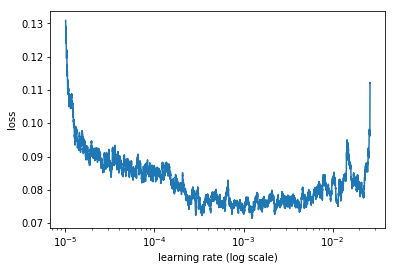

In [57]:
m.sched.plot()

In [ ]:
lr = 1e-5
m.fit(lrs=lr, n_cycle=3, metrics=[rmse], cycle_len=1, cycle_mult=2)

  3%|▎         | 601/22811 [00:06<03:43, 99.44it/s, loss=0.132] 
epoch      trn_loss   val_loss   rmse                              
    0      0.085104   0.087867   0.279173  
    1      0.076187   0.084828   0.275089                          
    2      0.075572   0.084804   0.275144                          
    3      0.071076   0.084849   0.274975                          
 77%|███████▋  | 17532/22811 [02:48<00:50, 103.99it/s, loss=0.07]  

In [ ]:
m.fit(1e-6, n_cycle=2, metrics=[rmse])

## Submit It!

In [ ]:
result = m.predict(is_test=True)
predictions = np.expm1(result).clip(0, 20)
display(predictions)

In [ ]:
final_dataframe = pd.read_csv(f'{PATH}test.csv')

In [ ]:
final_dataframe['item_cnt_month'] = predictions
final_dataframe = final_dataframe[['ID', 'item_cnt_month']]

In [ ]:
final_dataframe.head()

In [ ]:
len(final_dataframe)

In [ ]:
len(np.unique(final_dataframe['ID']))

In [ ]:
SUBM = 'sub/'
os.makedirs(SUBM, exist_ok=True)
final_dataframe.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [ ]:
FileLink(f'{SUBM}subm.gz')